In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-01 00:44:51.031767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dev = qml.device('default.mixed', wires=3)

In [3]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)

In [4]:
print(qml.draw(real)())

0: ──Rot(0.00,1.57,0.52)─┤  


In [5]:
def generator(w,**kwargs):
    qml.RX(w[0], wires=1)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=1)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=1)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[1,2])
    qml.RX(w[6], wires=1)
    qml.RY(w[7], wires=1)
    qml.RZ(w[8], wires=1)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=1)

In [6]:
print(qml.draw(generator)([ 0,0,0,0,0,0,0,0,0]))

1: ──RX(0.00)──RY(0.00)──RZ(0.00)─╭●──RX(0.00)──RY(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)─┤  
2: ──RX(0.00)──RY(0.00)──RZ(0.00)─╰X─────────────────────────────────────────────────────┤  


In [7]:
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(w[0], wires=0)
    qml.RZ(w[1], wires=1)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

In [8]:
print(qml.draw(discriminator)([ 0,1]))

0: ──H─╭Z──RZ(0.00)──H─┤  
1: ────╰●──RZ(1.00)──H─┤  


In [9]:
@qml.qnode(dev, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.PauliZ(0)+qml.Identity(0))@ (qml.PauliZ(1)+qml.Identity(1)))
#qml.expval(qml.PauliZ(0) @ qml.PauliX(2))


In [10]:
print(qml.draw(real_gen_disc_circuit)([ 0,0,0,0,0,0,0,0,0],[ 0,1]))

0: ──Rot(0.00,1.57,0.52)──H────────────────────────────────────────────────────────────────────────
1: ──RX(0.00)─────────────RY(0.00)──RZ(0.00)─╭●──RX(0.00)──RY(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)
2: ──RX(0.00)─────────────RY(0.00)──RZ(0.00)─╰X────────────────────────────────────────────────────

──╭Z──RZ(0.00)──H─┤ ╭<𝓗>
──╰●──RZ(1.00)──H─┤ ╰<𝓗>
──────────────────┤     


In [11]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/2
    return prob_discriminated_output

In [12]:
def disc_cost(disc_weights):
    cost = 1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [13]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*9)
init_disc_weights = np.random.normal(size=(9,))
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

2023-06-01 00:44:59.854400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
real_gen_disc_circuit(gen_weights, disc_weights)
prob_discriminated(gen_weights,disc_weights)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9238059425981906>

Step 0: cost = 0.0722169611690362
Step 5: cost = 0.0660113354825893
Step 10: cost = 0.0647025638697456
Step 15: cost = 0.0634115364067076
Step 20: cost = 0.06153952616697378
Step 25: cost = 0.058809578774053906
Step 30: cost = 0.05495547462442496
Step 35: cost = 0.049771374086292175
Step 40: cost = 0.04324360374679237
Step 45: cost = 0.03569093236947585
Step 0: cost = 0.9581812980133078
Step 5: cost = 0.7821139638615364
Step 10: cost = 0.33988306345838815
Step 15: cost = 0.05918268664644799
Step 20: cost = 0.006931248665881462
Step 25: cost = 0.0007568220809839321
Step 30: cost = 8.184332067828759e-05
Step 35: cost = 8.837027237806883e-06
Step 40: cost = 9.538751519211353e-07
Step 45: cost = 1.0295382146807697e-07
Step 0: cost = 0.9999999816859291
Step 5: cost = 0.9999999759596118
Step 10: cost = 0.9999999684402108
Step 15: cost = 0.9999999585602315
Step 20: cost = 0.9999999455451649
Step 25: cost = 0.9999999281991492
Step 30: cost = 0.9999999038496243
Step 35: cost = 0.999999862173443

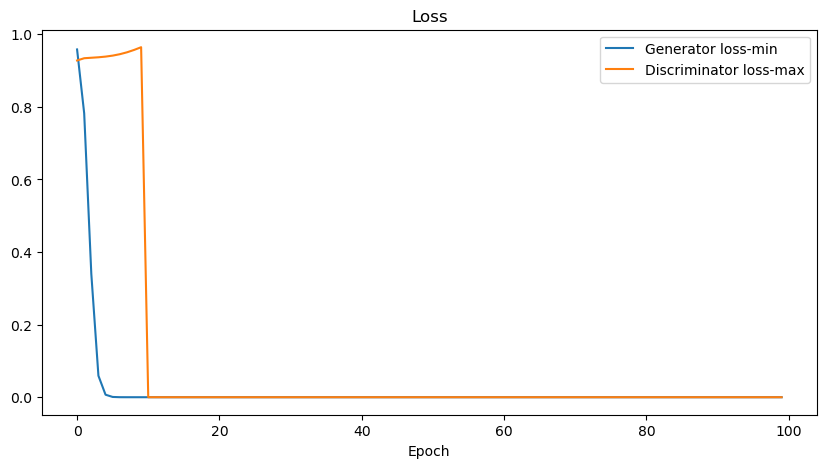

In [15]:
loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
p = 0.1
epochs = 10
for i in range(epochs):
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step_d.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))
    
loss_d = [ 1-x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_d, label="Discriminator loss-max")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

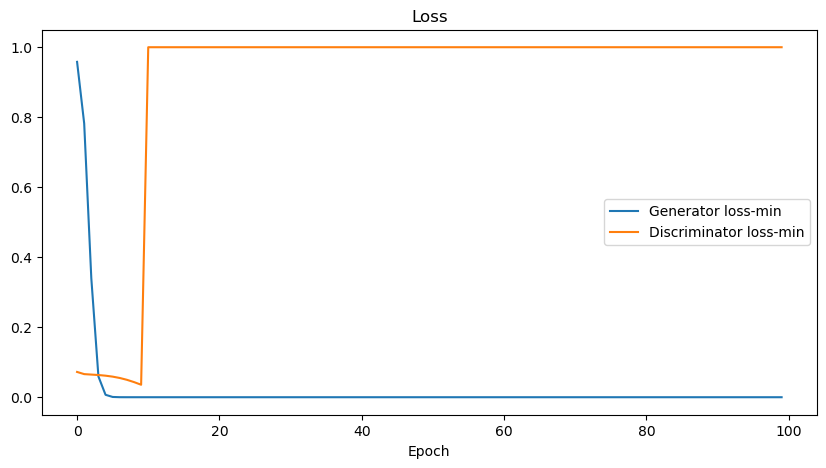

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()